In [1]:
import matplotlib.pyplot as plt
import numpy as np
import heapq
import logging
import sys
import time
import math
from capper import Reads
import capper

In [2]:
start_time = time.time()
# Parse the 1kg reads
reads_1kg_small = Reads("minimizers_1kg_single/minimizers_correct",
                  "minimizers_1kg_single/minimizers_incorrect",
              max_correct_reads=10000)
print("Got ", len(reads_1kg_small.reads), " in ", time.time() - start_time, " seconds")

Got  39668  in  44.60903286933899  seconds


In [3]:
start_time = time.time()
# Parse the hgsvc reads
reads_hgsvc_small = Reads("minimizers_hgsvc_single/minimizers_correct",
                  "minimizers_hgsvc_single/minimizers_incorrect",
              max_correct_reads=10000)
print("Got ", len(reads_hgsvc_small.reads), " in ", time.time() - start_time, " seconds")

Got  66097  in  101.92715191841125  seconds


In [4]:
def current_cap(r):
    return r.capped_map_q  # round(min(r.uncapped_map_q, f(r.xian_cap), r.vg_computed_cap, 60))

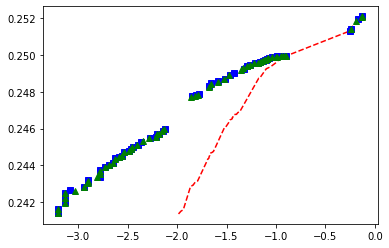

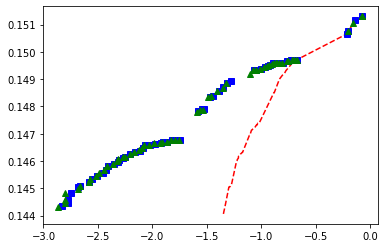

 Took  1.4726779460906982  seconds


In [102]:
## Make the small plots
def add_log(x, y):
    if (x > y):
        return x + math.log(1.0 + math.exp(y - x))
    else:
        return y + math.log(1.0 + math.exp(x - y))

def calc_map_q(r):
    if len(r.alignment_scores) == 0: # Case is unaligned
        return 0.0
    elif len(r.alignment_scores) == 1:
        if r.alignment_scores[0] == 0.0: # Case is unaligned
            return 0.0
        return 10000 # Case is the only alignment
    
    c = 1.38333
    def modified_alignment_score(i):
        alignment_score = r.alignment_scores[i] * c
        n = r.clusters[i][1][0]
        m = r.clusters[i][1][1]
        return alignment_score + (math.log(1 + (m - n)/n) if n < m else 0.0) 
    
    log_sum_exp = modified_alignment_score(0)
    for i in range(1,len(r.alignment_scores)): # Add from smallest to largest
        log_sum_exp = add_log(log_sum_exp, modified_alignment_score(i))
    
    max_score = r.alignment_scores[-1] * c

    if max_score == log_sum_exp:
        return 10000

    return -10 * math.log10(1.0 - math.exp(max_score - log_sum_exp))

def proposed_cap(r):
    map_q = calc_map_q(r)
    escape_bonus = 1.0 if map_q < 10000 else 2.0    
    return round(min(r.faster_cap_precomputed * escape_bonus, map_q, 60))

def make_rocs(reads):
    # Make ROC curves
    roc_unmodified = reads.get_roc()
    #print("Roc unmodified", roc_unmodified)
    roc_adam_modified = reads.get_roc(map_q_fn=current_cap)
    #print("Roc adam modified ", roc_adam_modified)
    start_time = time.time()
    roc_new_sum_modified = reads.get_roc(map_q_fn=proposed_cap)
    #print("Roc mode modified (time:{}) ".format(time.time()-start_time), roc_new_sum_modified)
    #Reads.plot_rocs([roc_unmodified, roc_adam_modified, roc_new_sum_modified])
    
    Reads.plot_rocs([roc_unmodified, roc_adam_modified, roc_new_sum_modified ])

start_time = time.time()
make_rocs(reads_1kg_small)
make_rocs(reads_hgsvc_small)
print(" Took ", time.time() - start_time, " seconds")

In [ ]:
start_time = time.time()
# Parse the hgsvc reads
reads_hgsvc = Reads("minimizers_hgsvc_single/minimizers_correct",
                    "minimizers_hgsvc_single/minimizers_incorrect",
              max_correct_reads=100000000)
print("Got ", len(reads_hgsvc.reads), " in ", time.time() - start_time, " seconds")

In [ ]:
start_time = time.time()
# Parse the 1kg reads
reads_1kg = Reads("minimizers_1kg_single/minimizers_correct",
                  "minimizers_1kg_single/minimizers_incorrect",
              max_correct_reads=100000000)
print("Got ", len(reads_1kg.reads), " in ", time.time() - start_time, " seconds")

In [ ]:
## Make the big plots

start_time = time.time()
make_rocs(reads_1kg)
make_rocs(reads_hgsvc)
print(" Took ", time.time() - start_time, " seconds")

In [101]:
#  Print some of the funky reads
def print_stages(reads, map_q):
    stages = {}
    total_wrong = 0
    total = 0
    for i, read in enumerate(reads.reads):
        if proposed_cap(read) >= map_q: # and read.stage == "cluster":
            total += 1
            if not read.correct:
                #print("Read {} {}".format(i, read))
                if read.stage not in stages:
                    stages[read.stage] = 0
                stages[read.stage] += 1
                total_wrong += 1
    print("Total", total, "Total wrong", total_wrong, "Wrong stages single end:", stages)
    
print("hgsvc")
print_stages(reads_hgsvc_small, 30)

print("1kg")
print_stages(reads_1kg_small, 30)

hgsvc
Total 10024 Total wrong 255 Wrong stages single end: {'none': 119, 'extend': 42, 'cluster': 54, 'align': 33, 'winner': 7}
1kg
Total 9964 Total wrong 137 Wrong stages single end: {'extend': 30, 'align': 41, 'cluster': 29, 'none': 37}
